## Transfer Learning InceptionV3 using Keras

Please download the dataset from the below url

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
import itertools

In [5]:
# re-size all the images to this
num_classes = 4
input_shape = (256, 256, 3)

train_path = '../data/dataset_original/'
val_path = '../data/dataset_original/'

<img src="https://github.com/bkget/Leaf-Disease-Classification/blob/main/screenshots/AlexNet%20Architecture.jpg?raw=true" alt="Alternative text"/>

In [6]:
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = input_shape
    chanDim = 1

alexnet_model = Sequential()
alexnet_model.add(Conv2D(filters=64, input_shape=input_shape, kernel_size=(3, 3), strides=(2,2), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#2nd
alexnet_model.add(Conv2D(filters=96, kernel_size=(5, 5), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.01)))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#3rd
alexnet_model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))


#4th
alexnet_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))

#5th
alexnet_model.add(Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
alexnet_model.add(Dropout(0.4))

# Flattening
alexnet_model.add(Flatten())

# FC layer
alexnet_model.add(Dense(2048))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.5))

#2nd FC layer
alexnet_model.add(Dense(2048))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

#Output layer
alexnet_model.add(Dense(4))
alexnet_model.add(Activation('softmax'))

alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 127, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 127, 127, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 96)        153696    
_________________________________________________________________
activation_1 (Activation)    (None, 59, 59, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       4

In [7]:
from keras.optimizers import Adam

opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [8]:
# tell the model what cost and optimization method to use
alexnet_model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

In [9]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             shear_range = 0.2, 
                             vertical_flip=True,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
# Make sure you provide the same target size as initialied for the image size
training_set = datagen.flow_from_directory(train_path,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 6418 images belonging to 4 classes.


In [11]:
test_set = datagen.flow_from_directory(val_path,
                                       target_size = (256, 256),
                                       batch_size = 32,
                                       subset = "validation",
                                       shuffle = False,
                                       class_mode = 'categorical')

Found 1604 images belonging to 4 classes.


In [12]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                             patience = 3, 
                                             verbose = 1, 
                                             factor = 0.5, 
                                             min_lr = 0.00001)

In [13]:
# fit the model
# Run the cell. It will take some time to execute
model_history = alexnet_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  callbacks = [learning_rate_reduction],
  steps_per_epoch = len(training_set),
  validation_steps = len(test_set)  
)

Epoch 1/50
201/201 [==============================] - 5850s 29s/step - loss: 14.2372 - accuracy: 0.2762 - val_loss: 2.1645 - val_accuracy: 0.3516
Epoch 2/50
201/201 [==============================] - 107s 533ms/step - loss: 1.9358 - accuracy: 0.4205 - val_loss: 1.8387 - val_accuracy: 0.5131
Epoch 3/50
201/201 [==============================] - 107s 534ms/step - loss: 1.6448 - accuracy: 0.5285 - val_loss: 1.8066 - val_accuracy: 0.5012
Epoch 4/50
201/201 [==============================] - 107s 533ms/step - loss: 1.5061 - accuracy: 0.5848 - val_loss: 1.5444 - val_accuracy: 0.5667
Epoch 5/50
201/201 [==============================] - 107s 534ms/step - loss: 1.4222 - accuracy: 0.6110 - val_loss: 1.5912 - val_accuracy: 0.5536
Epoch 6/50
201/201 [==============================] - 107s 534ms/step - loss: 1.3041 - accuracy: 0.6526 - val_loss: 1.5252 - val_accuracy: 0.5680
Epoch 7/50
201/201 [==============================] - 107s 533ms/step - loss: 1.2270 - accuracy: 0.6589 - val_loss: 1.7391 -

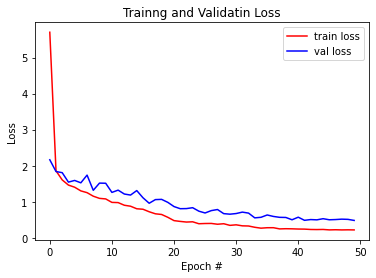

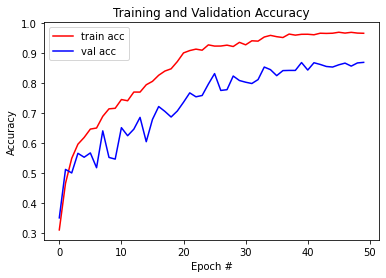

<Figure size 432x288 with 0 Axes>

In [14]:
# plot the loss
plt.plot(model_history.history['loss'],'r', label='train loss')
plt.plot(model_history.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'],'r', label='train acc')
plt.plot(model_history.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [15]:
#loss, accuracy = alexnet_model.evaluate(x_test, y_test, verbose=1)
loss, accuracy = alexnet_model.evaluate(test_set, verbose=1)
# loss_v, accuracy_v = alexnet_model.evaluate(x_validate, y_validate, verbose=1)
t_loss, t_accuracy = alexnet_model.evaluate(training_set, verbose=1)

201/201 [==============================] - 86s 425ms/step - loss: 0.2005 - accuracy: 0.9768


In [16]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.976784  ;  loss_v = 0.200526
Validation: accuracy = 0.877182  ;  loss = 0.490144


In [17]:
# save it as a h5 file
from tensorflow.keras.models import load_model

alexnet_model.save('../models/faba_bean_model_modified_AlexNet_original_1.h5')

In [18]:
# open saved model file
import keras
from tensorflow.keras.models import load_model
alexnet_model = keras.models.load_model('../models/faba_bean_model_modified_AlexNet_original_1.h5')

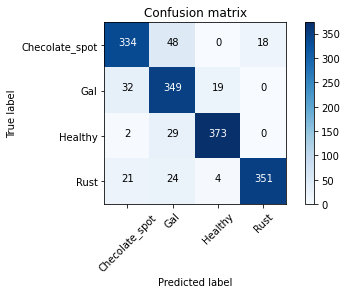

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = alexnet_model.predict(test_set,  1604 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate_spot', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

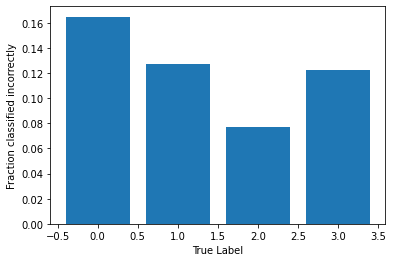

In [20]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [21]:
print('\nClassification Report\n')
class_labels = ['Checolate_spot', 'gal', 'healthy', 'rust']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.86      0.83      0.85       400
           gal       0.78      0.87      0.82       400
       healthy       0.94      0.92      0.93       404
          rust       0.95      0.88      0.91       400

      accuracy                           0.88      1604
     macro avg       0.88      0.88      0.88      1604
  weighted avg       0.88      0.88      0.88      1604

